# Определение стоимости автомобилей

Необходимо оценить рыночную стоимость автомобиля на основе исторических данных, включающих технические характеристики, комплектации и цены автомобилей.

## Подготовка данных

In [3]:
import warnings

warnings.filterwarnings("ignore")

In [5]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import time
import datetime

import sklearn
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split 

from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor

from sklearn.metrics import mean_squared_error

### Загрузка и первичный анализ

In [6]:
df = pd.read_csv('autos.csv')
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0.0,70435.0,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0.0,66954.0,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0.0,90480.0,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0.0,91074.0,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0.0,60437.0,2016-04-06 10:17:21


In [7]:
df.rename(columns={"NotRepaired":"repaired"}, inplace=True) 

In [8]:
df.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'repaired', 'DateCreated', 'NumberOfPictures', 'PostalCode',
       'LastSeen'],
      dtype='object')

Сразу видно, что названия столбцов нужно привести к змеиному формату, есть значения NaN, в датах где-то время указано, а где-то нет

In [9]:
df.columns = df.columns.str.lower()
df.columns

Index(['datecrawled', 'price', 'vehicletype', 'registrationyear', 'gearbox',
       'power', 'model', 'kilometer', 'registrationmonth', 'fueltype', 'brand',
       'repaired', 'datecreated', 'numberofpictures', 'postalcode',
       'lastseen'],
      dtype='object')

In [10]:
df.columns = ['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type', 'brand',
       'not_repaired', 'date_created', 'number_of_pictures', 'postal_code',
       'last_seen']
df.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'not_repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217788 entries, 0 to 217787
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   date_crawled        217788 non-null  object 
 1   price               217788 non-null  int64  
 2   vehicle_type        194728 non-null  object 
 3   registration_year   217788 non-null  int64  
 4   gearbox             205604 non-null  object 
 5   power               217788 non-null  int64  
 6   model               205598 non-null  object 
 7   kilometer           217788 non-null  int64  
 8   registration_month  217788 non-null  int64  
 9   fuel_type           197517 non-null  object 
 10  brand               217787 non-null  object 
 11  not_repaired        173986 non-null  object 
 12  date_created        217787 non-null  object 
 13  number_of_pictures  217787 non-null  float64
 14  postal_code         217787 non-null  float64
 15  last_seen           217787 non-nul

три колонки с датой следует перевести в соответствующий формат

In [12]:
df.isna().sum().sort_values(ascending = False)

not_repaired          43802
vehicle_type          23060
fuel_type             20271
model                 12190
gearbox               12184
brand                     1
date_created              1
number_of_pictures        1
postal_code               1
last_seen                 1
date_crawled              0
price                     0
registration_year         0
power                     0
kilometer                 0
registration_month        0
dtype: int64

пять колонок содержат пропуски

In [13]:
df.duplicated().sort_values(ascending = False)

171088     True
0         False
145195    False
145185    False
145186    False
          ...  
72599     False
72600     False
72601     False
72602     False
217787    False
Length: 217788, dtype: bool

всего лишь четыре строки являются явными дубликатами. Взглянем на них

In [14]:
df[df.duplicated() == True]

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0.0,89518.0,2016-03-09 09:46:57


In [15]:
df = df.drop_duplicates()

In [16]:
df.corr()

,price,registration_year,power,kilometer,registration_month,number_of_pictures,postal_code
price,1.000000,0.026145,0.156041,-0.332478,0.110939,NaN,0.076783
registration_year,0.026145,1.000000,0.000219,-0.051680,-0.011250,NaN,-0.001515
power,0.156041,0.000219,1.000000,0.019340,0.042686,NaN,0.022758
kilometer,-0.332478,-0.051680,0.019340,1.000000,0.010774,NaN,-0.008666
registration_month,0.110939,-0.011250,0.042686,0.010774,1.000000,NaN,0.012678
number_of_pictures,NaN,NaN,NaN,NaN,NaN,NaN,NaN
postal_code,0.076783,-0.001515,0.022758,-0.008666,0.012678,NaN,1.000000


In [17]:
df.describe()

,price,registration_year,power,kilometer,registration_month,number_of_pictures,postal_code
count,217787.000000,217787.000000,217787.000000,217787.000000,217787.000000,217786.0,217786.000000
mean,4421.583942,2004.214274,110.153310,128159.486103,5.705547,0.0,50508.560757
std,4522.469737,91.208785,194.496225,37919.752341,3.723357,0.0,25797.612369
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49393.000000
75%,6400.000000,2008.000000,141.000000,150000.000000,9.000000,0.0,71116.000000
max,20000.000000,9999.000000,19211.000000,150000.000000,12.000000,0.0,99998.000000


странные значения:
- нулевая цена
- 1000 и 9999 год регистрации
- 0 и 20000 мощность
- пробег, км больше похож на категориальный признак
- 0 месяц регистрации
- количество изображений не меняется, везде ноль
- почтовый код - будет ли играть значение при обучении? скорее всего нет

Последние три колонки можно сразу удалить, поскольку они не могут определять цену. Так же как и date_crawled.

In [18]:
df = df.drop(['date_crawled', 'registration_month', 'number_of_pictures', 'postal_code'], axis = 1)

### Предобработка данных

#### Целевой признак - цена

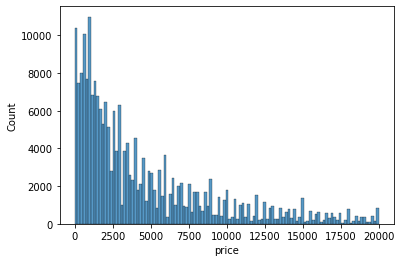

In [19]:
sns.histplot(df['price']);

распределение скошено вправо, что ожидаемо - дорогих автомобилей значительно меньше, чем дешёвых. Поскольку этот столбец является целевым, строки с нулевыми значениями придётся удалить, т.к. их нельзя будет использовать в обучении или валидации/тестировании

In [20]:
df = df.query('price > 0')

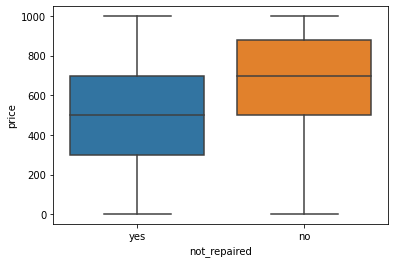

In [21]:
sns.boxplot(y = 'price', x = 'not_repaired', data= df.query('price < 1000'));

Похоже, следует воспринимать значение этого столбца наоборот, потому как не может отремонтированная машина, т.е. побывавшая в аварии, стоить дороже не побывавшей в ремонте. Предлагаю переименовать столбец во избежание путаницы

In [22]:
df.columns

Index(['price', 'vehicle_type', 'registration_year', 'gearbox', 'power',
       'model', 'kilometer', 'fuel_type', 'brand', 'not_repaired',
       'date_created', 'last_seen'],
      dtype='object')

In [23]:
df.columns = ['price', 'vehicle_type', 'registration_year', 'gearbox', 'power',
       'model', 'kilometer', 'fuel_type', 'brand', 'repaired',
       'date_created', 'last_seen']

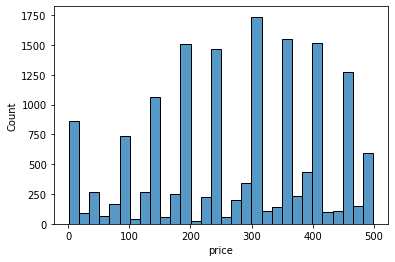

In [24]:
sns.histplot(df.query('price < 500')['price']);

из распределения видно, что чаще всего цену выставляют кратную 50 евро. Возможно, для упрощения стоит все цены привести к кратным 50 евро, с округлением в большую сторону (поскольку довольно много объявлений за 1 евро)

In [25]:
df['price'] = round(df['price']/50)*50

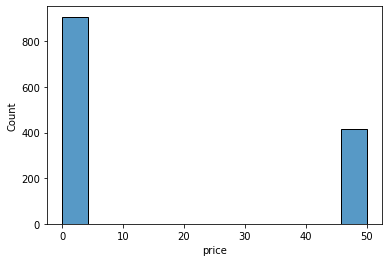

In [26]:
sns.histplot(df.query('price<100')['price']);

округлённые до 0 значения следует также удалить, т.к. цена была до 25 евро - гроши!

In [27]:
df = df.query('price > 0')

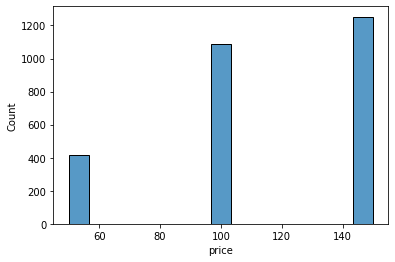

In [28]:
sns.histplot(df.query('price<200')['price']);

In [29]:
df['price'] = df['price'].astype(int)

Будем считать так-то лучше

In [30]:
# код ревьюера
df['price'].describe()

count    210164.000000
mean       4583.017786
std        4523.430280
min          50.000000
25%        1200.000000
50%        2900.000000
75%        6500.000000
max       20000.000000
Name: price, dtype: float64

#### Год регистрации

In [31]:
# первый автомобиль появился в 1885 году
df[df['registration_year'] < 1885]['registration_year'].count()

32

In [32]:
df[df['registration_year'] > 2022]['registration_year'].count()

48

строки с этими значениями можно преспокойно сносить, их немного, а модель они попортят

In [33]:
df = df.query('1885 < registration_year < 2022')

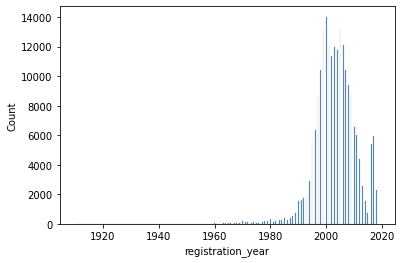

In [34]:
sns.histplot(df['registration_year']);

что это за авто с годом регистрации до 1960?

In [35]:
df.query('registration_year < 1960')

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired,date_created,last_seen
15,450,small,1910,NaN,0,ka,5000,petrol,ford,NaN,2016-03-11 00:00:00,2016-03-19 08:46:47
1928,7000,suv,1945,manual,48,other,150000,petrol,volkswagen,no,2016-03-25 00:00:00,2016-03-25 15:58:21
2273,1800,convertible,1925,NaN,0,NaN,5000,NaN,sonstige_autos,no,2016-03-15 00:00:00,2016-04-07 05:15:34
3333,10500,sedan,1955,manual,30,other,60000,petrol,ford,NaN,2016-03-15 00:00:00,2016-04-07 08:16:11
6977,150,NaN,1910,NaN,0,NaN,5000,NaN,opel,NaN,2016-03-24 00:00:00,2016-04-06 20:46:08
...,...,...,...,...,...,...,...,...,...,...,...,...
209144,350,suv,1956,NaN,0,NaN,5000,petrol,sonstige_autos,NaN,2016-03-11 00:00:00,2016-03-11 08:52:23
211397,6500,sedan,1959,manual,101,other,125000,petrol,bmw,yes,2016-03-05 00:00:00,2016-04-07 14:58:39
212091,200,NaN,1910,NaN,0,NaN,5000,NaN,trabant,NaN,2016-04-02 00:00:00,2016-04-06 22:44:37
216233,6500,other,1950,manual,0,NaN,5000,other,sonstige_autos,no,2016-03-24 00:00:00,2016-04-06 03:44:53


фольксваген пассат начали производить с 1973 года, дорогие мои. А тут указано 1953... явно ошибка...

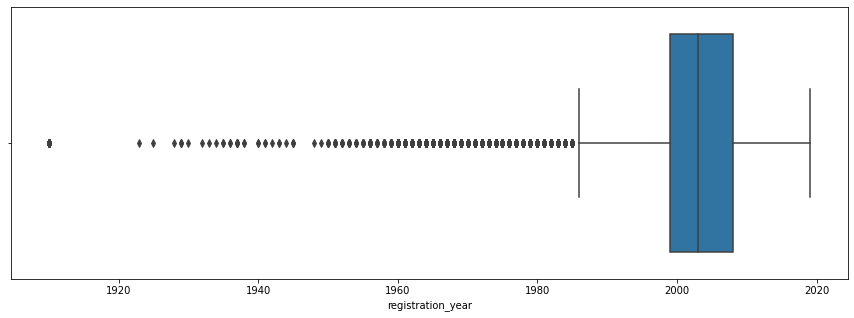

In [36]:
plt.figure(figsize=(15, 5))
sns.boxplot(df['registration_year']);

похоже, лучше избавиться от значений до 1985 г., это выбросы

In [37]:
df = df.query('registration_year > 1985')

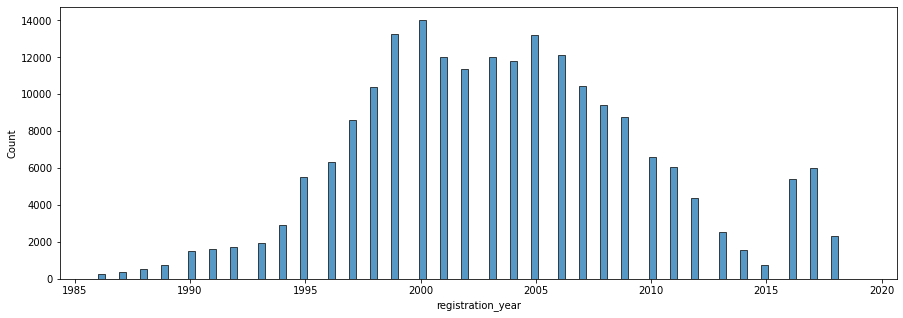

In [38]:
plt.figure(figsize=(15, 5))
sns.histplot(df['registration_year']);

распределение имеет три вершины - ~1998, 2005 и 2017. Возможно, значения после 2015 будут мешать, поскольку образуют отдельный пик на краю, и от них стоит избавиться

In [39]:
df = df.query('registration_year < 2016')

#### Мощность

In [40]:
df[df['power'] < 50]['power'].value_counts()

0     17402
45     1624
41      272
44      173
40      145
26       85
39       63
5        62
43       60
48       38
42       30
46       26
33       24
11       21
37       20
34       19
4        17
47       16
27       15
1        11
15       10
24        9
14        9
6         8
49        8
25        7
7         7
12        7
20        7
2         6
29        4
23        4
19        4
8         4
18        4
38        4
30        4
16        3
35        3
17        2
10        2
3         2
32        2
31        2
9         1
22        1
21        1
36        1
Name: power, dtype: int64

In [41]:
# максимальная мощность 4000 л.с у грузового автомобиля и 1750 у легкового
df.query('power > 1750').pivot_table(index = ['brand','model','vehicle_type'], values = 'power', aggfunc = ['min','max','mean','count'])

min    max          mean count
                                        power  power         power power
brand         model       vehicle_type                                  
alfa_romeo    147         small         15020  15020  15020.000000     1
              other       coupe         15033  15033  15033.000000     1
audi          80          sedan         11635  11635  11635.000000     1
                          wagon         17410  17410  17410.000000     1
              a3          sedan         17011  17011  17011.000000     1
              a4          convertible   16312  16312  16312.000000     1
                          wagon          1896  11011   6453.500000     2
              a6          wagon          2331   2331   2331.000000     1
bmw           1er         sedan         19211  19211  19211.000000     1
              3er         convertible    2016   2016   2016.000000     1
                          sedan          1895   1993   1944.000000     2
                          wagon         17019  17019  17019.000000     1
              5er         wagon          2729  19208  13212.333333     3
chevrolet     spark       small          8259   8259   8259.000000     1
citroen       berlingo    wagon          1780   1780   1780.000000     1
              c5          wagon          1900   1900   1900.000000     1
              other       wagon          2000   2000   2000.000000     1
fiat          seicento    small          5411   5411   5411.000000     1
              stilo       coupe          1900   1900   1900.000000     1
                          wagon          1920   1920   1920.000000     1
ford          fiesta      small         15001  15001  15001.000000     1
              focus       wagon          1753  11530   5012.000000     3
kia           ceed        wagon         11509  11509  11509.000000     1
mercedes_benz c_klasse    sedan          2799   2799   2799.000000     1
                          wagon          1796   1796   1796.000000     1
              e_klasse    sedan          1771   3454   2612.500000     2
                          wagon          3199   3199   3199.000000     1
              s_klasse    coupe          2789   2789   2789.000000     1
              sprinter    wagon          2005   2005   2005.000000     1
mini          cooper      small          6018   6018   6018.000000     1
opel          agila       sedan          6010   6010   6010.000000     1
                          small          5867   5867   5867.000000     1
              astra       sedan         12510  12510  12510.000000     1
                          small          7508   7508   7508.000000     1
              corsa       sedan          6512   6512   6512.000000     1
                          small          5809   5809   5809.000000     1
              omega       sedan         17932  17932  17932.000000     1
              vectra      sedan          1800   1800   1800.000000     1
                          small          1800   1800   1800.000000     1
                          wagon          2172   2172   2172.000000     1
renault       laguna      sedan          1998   1998   1998.000000     1
              megane      convertible   10710  10710  10710.000000     1
              twingo      small          5815   5815   5815.000000     1
seat          ibiza       small          4400   4400   4400.000000     1
smart         fortwo      convertible   10218  10218  10218.000000     1
                          small          6226   6226   6226.000000     1
suzuki        other       small          8404   8404   8404.000000     1
toyota        aygo        small          6920   6920   6920.000000     1
volkswagen    caddy       bus           10520  10520  10520.000000     1
              golf        convertible    7512   7512   7512.000000     1
                          sedan          1781   7544   3702.000000     3
                          wagon          1999   1999   1999.000000     1
              lupo        s

In [42]:
df.query('power > 1750')['power'].count()

80

строк не много, можно удалять без проблем

In [43]:
df = df.query('0 < power < 1750')

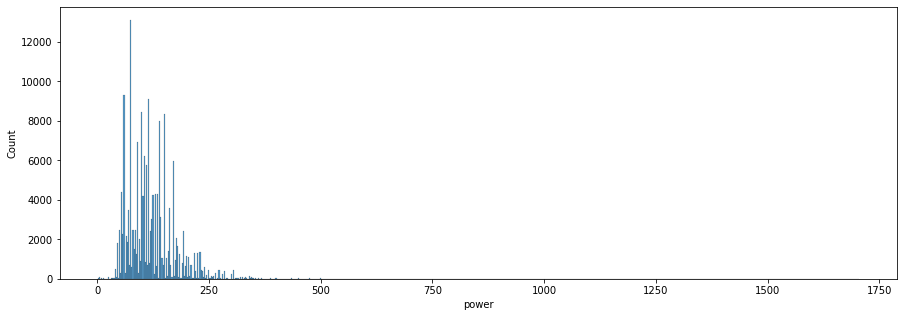

In [44]:
plt.figure(figsize=(15, 5))
sns.histplot(df['power']);

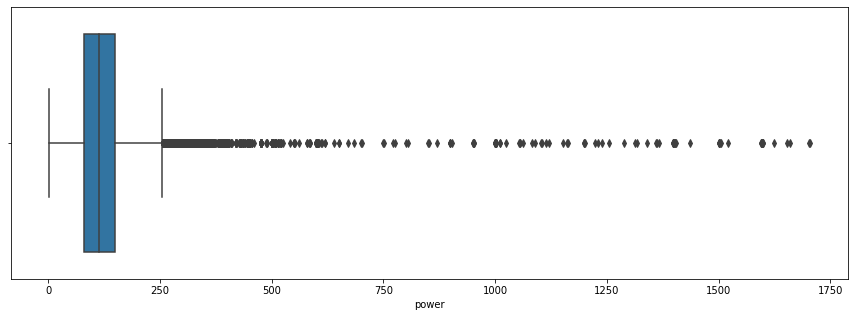

In [45]:
plt.figure(figsize=(15, 5))
sns.boxplot(df['power']);

всё, что больше 250 л.с. - выбросы, придётся от них избавиться

In [46]:
df.query('power > 250')['power'].count()

4155

In [47]:
df = df.query('0 < power < 250')

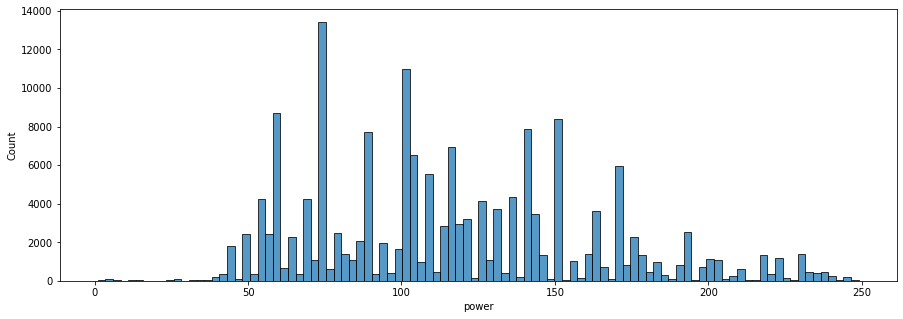

In [48]:
plt.figure(figsize=(15, 5))
sns.histplot(df['power']);

строки со значениями меньше 50 л.с.тоже можно отсечь

In [49]:
df = df.query('50 < power < 250')

#### Пробег

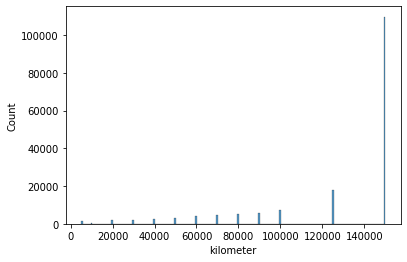

In [50]:
sns.histplot(df['kilometer']);

In [51]:
df['kilometer'].value_counts()

150000    109786
125000     17821
100000      7084
90000       5702
80000       5105
70000       4492
60000       3937
50000       3242
40000       2588
30000       2256
20000       1824
5000        1256
10000        504
Name: kilometer, dtype: int64

количество категорий не велико, так что можно преобразовать в категориальный признак

In [52]:
df['kilometer'] = df['kilometer'].astype(str)

In [53]:
df.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired,date_created,last_seen
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes,2016-03-24 00:00:00,2016-04-07 01:46:50
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN,2016-03-14 00:00:00,2016-04-05 12:47:46
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no,2016-03-17 00:00:00,2016-03-17 17:40:17
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no,2016-03-31 00:00:00,2016-04-06 10:17:21
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes,2016-04-04 00:00:00,2016-04-06 19:17:07


#### Коробка передач

In [54]:
df['gearbox'].value_counts()

manual    131841
auto       31213
Name: gearbox, dtype: int64

In [55]:
gearbox_table = df.pivot_table(index = ['brand', 'model', 'registration_year', 'vehicle_type', 'power'], values = 'gearbox', aggfunc = ['count', lambda x : x.isna().sum()]).sort_values(by = ('count', 'gearbox'), ascending = False)

gearbox_table.columns.set_levels(['count','nan_count'],level=0,inplace=True)
gearbox_table[gearbox_table[('nan_count','gearbox')] > 0].sort_values(by = ('count', 'gearbox'), ascending = False)

count nan_count
                                                         gearbox   gearbox
brand      model    registration_year vehicle_type power                  
volkswagen golf     1999              sedan        75        311         2
                    1998              sedan        75        260         4
           passat   2006              wagon        140       235         2
           polo     1997              small        60        213         4
           golf     1998              sedan        101       209         1
...                                                          ...       ...
smart      roadster 2004              convertible  101         0         1
audi       a6       1998              sedan        121         0         1
ford       escort   1989              convertible  150         0         1
citroen    other    2000              bus          130         0         1
seat       leon     2008              sedan        86          0         1

[1436 rows x 2 columns]

In [56]:
# для примера возьмём volkswagen golf с первой строки
df.query('model == "golf" and registration_year == 1999 and power == 75')[['vehicle_type', 'registration_year', 'gearbox', 'power', 'fuel_type', 'price']].sort_values(by = 'gearbox').head()

,vehicle_type,registration_year,gearbox,power,fuel_type,price
203026,sedan,1999,auto,75,petrol,800
778,sedan,1999,manual,75,petrol,1000
141351,small,1999,manual,75,petrol,1000
140695,wagon,1999,manual,75,petrol,1000
140018,sedan,1999,manual,75,petrol,1600


Видим, что заполнить пропуски коробки передач на основе других признаков не удастся - разные типы коробки передач обладают одними и теми же другими признаками. Вероятно, строки с пропусками придётся удалять

In [57]:
df = df[df['gearbox'].isna() == False]

In [58]:
df.isna().sum().sort_values(ascending = False)

repaired             21212
fuel_type             6609
model                 5063
vehicle_type          2195
brand                    1
date_created             1
last_seen                1
price                    0
registration_year        0
gearbox                  0
power                    0
kilometer                0
dtype: int64

#### Тип кузова

In [59]:
df.isna().sum().sort_values(ascending = False)

repaired             21212
fuel_type             6609
model                 5063
vehicle_type          2195
brand                    1
date_created             1
last_seen                1
price                    0
registration_year        0
gearbox                  0
power                    0
kilometer                0
dtype: int64

In [60]:
df.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired,date_created,last_seen
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes,2016-03-24 00:00:00,2016-04-07 01:46:50
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN,2016-03-14 00:00:00,2016-04-05 12:47:46
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no,2016-03-17 00:00:00,2016-03-17 17:40:17
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no,2016-03-31 00:00:00,2016-04-06 10:17:21
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes,2016-04-04 00:00:00,2016-04-06 19:17:07


In [61]:
df['vehicle_type'].value_counts()

sedan          47306
small          37430
wagon          35064
bus            15773
convertible    10624
coupe           7440
suv             5913
other           1309
Name: vehicle_type, dtype: int64

In [62]:
vehicle_type_table = df.pivot_table(index = ['brand', 'model', 'registration_year', 'gearbox', 'power'], values = 'vehicle_type', aggfunc = ['count', lambda x : x.isna().sum()]).sort_values(by = ('count', 'vehicle_type'), ascending = False)

vehicle_type_table.columns.set_levels(['count','nan_count'],level=0,inplace=True)
vehicle_type_table[vehicle_type_table[('nan_count','vehicle_type')] > 0].sort_values(by = ('count', 'vehicle_type'), ascending = False)

count  \
                                                       vehicle_type   
brand         model    registration_year gearbox power                
volkswagen    golf     1999              manual  75             472   
                       2000              manual  75             256   
                       1995              manual  75             233   
                       2010              manual  105            197   
opel          astra    1998              manual  75             191   
...                                                             ...   
mazda         mx_reihe 1995              manual  133              0   
ford          mondeo   2005              manual  108              0   
mercedes_benz e_klasse 1990              auto    140              0   
mazda         mx_reihe 2000              auto    107              0   
volkswagen    golf     1990              manual  210              0   

                                                          nan_count  
                                                       vehicle_type  
brand         model    registration_year gearbox power               
volkswagen    golf     1999              manual  75               2  
                       2000              manual  75              45  
                       1995              manual  75              28  
                       2010              manual  105              3  
opel          astra    1998              manual  75               1  
...                                                             ...  
mazda         mx_reihe 1995              manual  133              1  
ford          mondeo   2005              manual  108              1  
mercedes_benz e_klasse 1990              auto    140              1  
mazda         mx_reihe 2000              auto    107              1  
volkswagen    golf     1990              manual  210              1  

[1231 rows x 2 columns]

In [63]:
# для примера возьмём volkswagen golf с первой строки
df.query('model == "golf" and registration_year == 1999 and power == 75')[['vehicle_type', 'registration_year', 'gearbox', 'power', 'fuel_type', 'price']].sort_values(by = 'vehicle_type').head(60)

,vehicle_type,registration_year,gearbox,power,fuel_type,price
104753,convertible,1999,manual,75,petrol,750
104907,convertible,1999,manual,75,petrol,3250
76368,convertible,1999,manual,75,petrol,1200
110626,convertible,1999,manual,75,petrol,1150
127343,convertible,1999,manual,75,petrol,1950
144922,convertible,1999,manual,75,petrol,3000
34132,convertible,1999,manual,75,petrol,1950
184692,convertible,1999,manual,75,petrol,500
208458,convertible,1999,manual,75,petrol,1450
211058,convertible,1999,manual,75,petrol,2000


Видим, что заполнить пропуски типа кузова на основе других признаков не удастся - разные типы кузова обладают одними и теми же жругими признаками. Вероятно, строки с пропусками придётся удалять

In [64]:
df = df[df['vehicle_type'].isna() == False]

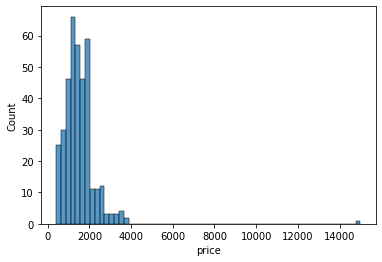

In [113]:
sns.histplot(df.query('model == "golf" and registration_year == 1999 and power == 75')['price']);

In [66]:
df.query('model == "golf" and registration_year == 1999 and power == 75').sort_values(by='price', ascending = False).head(3)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired,date_created,last_seen
10962,15000,sedan,1999,manual,75,golf,150000,petrol,volkswagen,no,2016-03-13 00:00:00,2016-04-06 17:47:01
91523,3700,small,1999,manual,75,golf,80000,petrol,volkswagen,no,2016-03-07 00:00:00,2016-03-08 18:31:36
27104,3700,small,1999,manual,75,golf,80000,petrol,volkswagen,no,2016-03-07 00:00:00,2016-03-08 23:29:59


Видимо, на нём ездила Королева английская

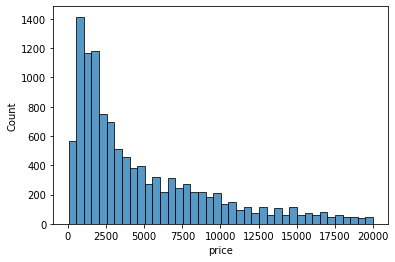

In [114]:
sns.histplot(df.query('model == "golf"')['price'])

In [68]:
df.isna().sum().sort_values(ascending = False)

repaired             20062
fuel_type             5713
model                 4742
brand                    1
date_created             1
last_seen                1
price                    0
vehicle_type             0
registration_year        0
gearbox                  0
power                    0
kilometer                0
dtype: int64

#### Модель

In [69]:
model_table = df.pivot_table(index = ['brand', 'registration_year', 'vehicle_type', 'power', 'gearbox'], values = 'model', aggfunc = ['count', lambda x : x.isna().sum()]).sort_values(by = ('count', 'model'), ascending = False)

model_table.columns.set_levels(['count','nan_count'],level=0,inplace=True)
model_table[model_table[('nan_count','model')] > 0].sort_values(by = ('count', 'model'), ascending = False)

count nan_count
                                                        model     model
brand      registration_year vehicle_type power gearbox                
volkswagen 1999              sedan        75    manual    318        10
           1998              sedan        75    manual    261         5
           1997              small        60    manual    260        13
opel       2001              small        58    manual    231         6
renault    1999              small        58    manual    229         9
...                                                       ...       ...
mitsubishi 2002              sedan        125   manual      0         1
toyota     2009              sedan        91    manual      0         1
chrysler   2002              convertible  141   manual      0         1
honda      1996              convertible  160   manual      0         1
chevrolet  1998              bus          186   auto        0         1

[3422 rows x 2 columns]

In [70]:
# для примера возьмём volkswagen с первой строки
df.query('brand =="volkswagen" and registration_year == 1999 and vehicle_type =="sedan" and power == 75')[['vehicle_type', 'registration_year', 'gearbox', 'power', 'fuel_type', 'price', 'model']].sort_values(by = 'model').head()

,vehicle_type,registration_year,gearbox,power,fuel_type,price,model
58965,sedan,1999,manual,75,petrol,2000,bora
778,sedan,1999,manual,75,petrol,1000,golf
148082,sedan,1999,manual,75,petrol,900,golf
146683,sedan,1999,manual,75,petrol,2400,golf
142974,sedan,1999,manual,75,petrol,1600,golf


In [71]:
# для примера возьмём volkswagen с первой строки
df.query('brand =="volkswagen" and registration_year == 1999 and vehicle_type =="sedan" and power == 75 and gearbox == "manual"')['model'].value_counts()

golf    310
polo      6
lupo      1
bora      1
Name: model, dtype: int64

Видим, что заполнить пропуски модели на основе других признаков не удастся - разные модели обладают одними и теми же другими признаками. Можно либо заполнить наиболее часто встречаемым, либо удалить. Вероятно, строки с пропусками придётся удалять

In [72]:
df = df[df['model'].isna() == False]

In [73]:
df.isna().sum().sort_values(ascending = False)

repaired             18648
fuel_type             4821
brand                    1
date_created             1
last_seen                1
price                    0
vehicle_type             0
registration_year        0
gearbox                  0
power                    0
model                    0
kilometer                0
dtype: int64

#### Тип двигателя (по топливу)

In [74]:
df['fuel_type'].value_counts()

petrol      98248
gasoline    50345
lpg          2272
cng           285
hybrid        107
other          25
electric       13
petr            1
Name: fuel_type, dtype: int64

In [75]:
fuel_table = df.pivot_table(index = ['brand', 'registration_year', 'vehicle_type', 'power', 'gearbox'], values = 'fuel_type', aggfunc = ['count', lambda x : x.isna().sum()]).sort_values(by = ('count', 'fuel_type'), ascending = False)

fuel_table.columns.set_levels(['count','nan_count'],level=0,inplace=True)
fuel_table[fuel_table[('nan_count','fuel_type')] > 0].sort_values(by = ('count', 'fuel_type'), ascending = False)

count nan_count
                                                        fuel_type fuel_type
brand      registration_year vehicle_type power gearbox                    
volkswagen 1999              sedan        75    manual        306        12
           1998              sedan        75    manual        253         8
           1997              small        60    manual        241        19
opel       2001              small        58    manual        228         3
volkswagen 1998              sedan        101   manual        221         6
...                                                           ...       ...
opel       1994              convertible  70    manual          0         1
ford       2006              bus          98    manual          0         1
suzuki     1996              other        56    manual          0         1
jaguar     2002              sedan        196   auto            0         1
volkswagen 2010              sedan        90    auto            0         1

[3359 rows x 2 columns]

In [76]:
# для примера возьмём volkswagen с первой строки
df.query('brand =="volkswagen" and registration_year == 1999 and vehicle_type =="sedan" and power == 75 and gearbox =="manual"')['fuel_type'].value_counts()

petrol    304
lpg         2
Name: fuel_type, dtype: int64

Видим, что заполнить пропуски типа двигателя на основе других признаков не удастся - разные двигатели обладают одними и теми же другими признаками. Можно либо заполнить наиболее часто встречаемым, либо удалить. Вероятно, строки с пропусками придётся удалять

In [77]:
df = df[df['fuel_type'].isna() == False]

In [78]:
df.isna().sum().sort_values(ascending = False)

repaired             16994
brand                    1
date_created             1
last_seen                1
price                    0
vehicle_type             0
registration_year        0
gearbox                  0
power                    0
model                    0
kilometer                0
fuel_type                0
dtype: int64

#### Ремонт

In [79]:
not_repaired_table = df.pivot_table(index = ['brand', 'registration_year', 'vehicle_type', 'power', 'gearbox', 'price'], values = 'repaired', aggfunc = ['count', lambda x : x.isna().sum()]).sort_values(by = ('count', 'repaired'), ascending = False)

not_repaired_table.columns.set_levels(['count','nan_count'],level=0,inplace=True)
not_repaired_table[not_repaired_table[('nan_count','repaired')] > 0].sort_values(by = ('count', 'repaired'), ascending = False)

count  \
                                                              repaired   
brand      registration_year vehicle_type power gearbox price            
opel       2000              small        54    manual  1000        22   
volkswagen 1998              sedan        75    manual  1400        21   
           1999              small        75    manual  1000        19   
           1998              sedan        101   manual  1000        19   
           1999              sedan        75    manual  1200        18   
...                                                                ...   
audi       1994              wagon        116   manual  450          0   
           2003              coupe        150   manual  5500         0   
volkswagen 2010              sedan        105   manual  11100        0   
audi       2003              coupe        140   manual  6100         0   
skoda      2011              sedan        60    manual  6500         0   

                                                              nan_count  
                                                               repaired  
brand      registration_year vehicle_type power gearbox price            
opel       2000              small        54    manual  1000          2  
volkswagen 1998              sedan        75    manual  1400          2  
           1999              small        75    manual  1000          1  
           1998              sedan        101   manual  1000          1  
           1999              sedan        75    manual  1200          1  
...                                                                 ...  
audi       1994              wagon        116   manual  450           1  
           2003              coupe        150   manual  5500          1  
volkswagen 2010              sedan        105   manual  11100         2  
audi       2003              coupe        140   manual  6100          1  
skoda      2011              sedan        60    manual  6500          1  

[15305 rows x 2 columns]

In [80]:
# для примера возьмём volkswagen с первой строки
df.query('brand =="volkswagen" and registration_year == 1999 and vehicle_type =="sedan" and power == 75 and gearbox =="manual"')['repaired'].value_counts()

no     229
yes     33
Name: repaired, dtype: int64

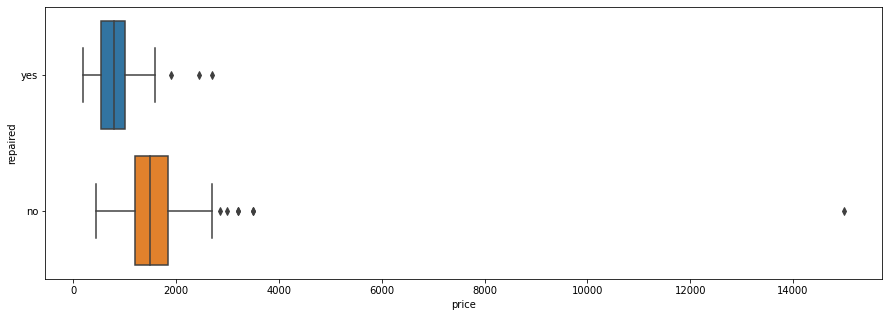

In [81]:
plt.figure(figsize=(15, 5))
sns.boxplot(x='price', y ='repaired', data = df.query('brand =="volkswagen" and registration_year == 1999 and vehicle_type =="sedan" and power == 75 and gearbox =="manual"'));

Как и было показано ранее, да и следуя реальности, автомобили, побывавшие в ремонте будут стоить дешевле их не отремонтированных аналогов. Исключение - если автомобиль продаётся битым. Но такого признака у нас нет, поэтому удалим значения с пропусками в колонке repaired.

In [82]:
df = df[df['repaired'].isna() == False]

## Обучение моделей

### Создание новых признаков

длительность размещения объявления может говорить о том насколько справедлива (соответствует рынку, в частности не завышена или не занижена) цена, поэтому можно создать новый признак

In [83]:
df['last_seen'] = pd.to_datetime(df['last_seen'])
df['date_created'] = pd.to_datetime(df['date_created'])

In [84]:
df['duration'] = (df['last_seen'] - df['date_created']).dt.days
df['duration']

3          0
4          6
5          2
6          4
10        11
          ..
217779     3
217780     8
217783     3
217785     1
217786     0
Name: duration, Length: 134302, dtype: int64

In [85]:
df = df.drop(['last_seen', 'date_created'], axis = 1)

### Подготовка данных

In [86]:
encoder = OrdinalEncoder()
df_ord = pd.DataFrame(encoder.fit_transform(df),
                            columns=df.columns)

In [87]:
features_ord = df_ord.drop(['price'], axis=1)
target_ord = df_ord['price']

features_train_ord, features_valid_and_test_ord, target_train_ord, target_valid_and_test_ord = train_test_split(
    features_ord, target_ord, test_size = 0.2, random_state = 12345)

features_test_ord, features_valid_ord, target_test_ord, target_valid_ord = train_test_split(
    features_valid_and_test_ord, target_valid_and_test_ord, test_size = 0.5, random_state = 12345)

print('features_train_ord', features_train_ord.shape)
print('features_valid_ord', features_valid_ord.shape)
print('features_test_ord', features_test_ord.shape)

print('target_train_ord', target_train_ord.shape)
print('target_valid_ord', target_valid_ord.shape)
print('target_test_ord', target_test_ord.shape)

features_train_ord (107441, 10)
features_valid_ord (13431, 10)
features_test_ord (13430, 10)
target_train_ord (107441,)
target_valid_ord (13431,)
target_test_ord (13430,)


In [88]:
numeric = ['registration_year', 'power', 'duration']

In [89]:
scaler = StandardScaler()

scaler.fit(features_train_ord[numeric])
features_train_ord[numeric] = scaler.transform(features_train_ord[numeric])
features_valid_ord[numeric] = scaler.transform(features_valid_ord[numeric])
features_test_ord[numeric] = scaler.transform(features_test_ord[numeric])

### Линейная регрессия

In [90]:
%%time

lr_model = LinearRegression()

print(-cross_val_score(lr_model, features_train_ord, target_train_ord, scoring = 'neg_root_mean_squared_error', cv = 5).mean())

53.836644882185325
CPU times: user 256 ms, sys: 201 ms, total: 456 ms
Wall time: 271 ms


In [91]:
lr_model.fit(features_train_ord, target_train_ord)
lr_predictions = lr_model.predict(features_valid_ord)
print('RMSE модели линейной регрессии на тестовой выборке', mean_squared_error(target_valid_ord, lr_predictions)**0.5)

RMSE модели линейной регрессии на тестовой выборке 52.533033129788


### Дерево решений

In [92]:
%%time

dt_model = DecisionTreeRegressor()

print(-cross_val_score(dt_model, features_train_ord, target_train_ord, scoring = 'neg_root_mean_squared_error', cv = 5).mean())

40.7815403617858
CPU times: user 2.38 s, sys: 109 ms, total: 2.49 s
Wall time: 2.44 s


In [93]:
dt_model.fit(features_train_ord, target_train_ord)
dt_predictions = dt_model.predict(features_valid_ord)
print('RMSE модели дерева решений на тестовой выборке', mean_squared_error(target_valid_ord, dt_predictions)**0.5)

RMSE модели дерева решений на тестовой выборке 39.085486951509374


### Случайный лес

In [94]:
%%time

rf_model = RandomForestRegressor()

print(-cross_val_score(rf_model, features_train_ord, target_train_ord, scoring = 'neg_root_mean_squared_error', cv = 5).mean())

30.888307342559205
CPU times: user 2min 25s, sys: 1.55 s, total: 2min 26s
Wall time: 2min 27s


In [95]:
rf_model.fit(features_train_ord, target_train_ord)
rf_predictions = rf_model.predict(features_valid_ord)
print('RMSE модели случайного леса на тестовой выборке', mean_squared_error(target_valid_ord, rf_predictions)**0.5)

RMSE модели случайного леса на тестовой выборке 29.6975335859733


### Градиентный спуск

#### Обучение на случайных гиперпараметрах

In [96]:
%%time

lgb_train = lgb.Dataset(features_train_ord, target_train_ord)
lgb_eval = lgb.Dataset(features_valid_ord, target_valid_ord, reference=lgb_train)

params = {
    'boosting_type': 'gbdt', # gradient-based decision tree
    'objective': 'regression',
    'metric': {'l2', 'l1'}, #loss squared, absolute loss
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9, # LightGBM will randomly select a subset of features on each iteration (tree) if feature_fraction is smaller than 1.0
    'bagging_fraction': 0.8, # like feature_fraction, but this will randomly select part of data without resampling
    'bagging_freq': 5, # 0 means disable bagging; k means perform bagging at every k iteration
    'verbose': 0
}

gbm = lgb.train(params,
                lgb_train,
                num_boost_round=20,
                valid_sets=lgb_eval,
                callbacks=[lgb.early_stopping(stopping_rounds=5)])

y_pred = gbm.predict(features_valid_ord, num_iteration=gbm.best_iteration)

rmse_test = mean_squared_error(target_valid_ord, y_pred) ** 0.5
print(f'The RMSE of prediction is: {rmse_test}')

[1]	valid_0's l2: 7739.4	valid_0's l1: 70.4865
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l2: 7160.97	valid_0's l1: 67.6748
[3]	valid_0's l2: 6753.44	valid_0's l1: 65.6055
[4]	valid_0's l2: 6267.81	valid_0's l1: 63.0637
[5]	valid_0's l2: 5826.62	valid_0's l1: 60.6488
[6]	valid_0's l2: 5430.22	valid_0's l1: 58.4002
[7]	valid_0's l2: 5068.79	valid_0's l1: 56.2738
[8]	valid_0's l2: 4759.92	valid_0's l1: 54.3854
[9]	valid_0's l2: 4460.93	valid_0's l1: 52.5271
[10]	valid_0's l2: 4188.9	valid_0's l1: 50.7684
[11]	valid_0's l2: 3940.43	valid_0's l1: 49.1112
[12]	valid_0's l2: 3716.31	valid_0's l1: 47.5547
[13]	valid_0's l2: 3513.01	valid_0's l1: 46.1164
[14]	valid_0's l2: 3329.53	valid_0's l1: 44.7551
[15]	valid_0's l2: 3159.45	valid_0's l1: 43.4739
[16]	valid_0's l2: 3006.23	valid_0's l1: 42.2894
[17]	valid_0's l2: 2867.34	valid_0's l1: 41.1739
[18]	valid_0's l2: 2753.02	valid_0's l1: 40.2435
[19]	valid_0's l2: 2634.4	valid_0's l1: 39.2604
[20]	valid_0's l2: 2

Метрика RMSE лучше логистрической регресии, но хуже "деревянных" регрессоров sklearn

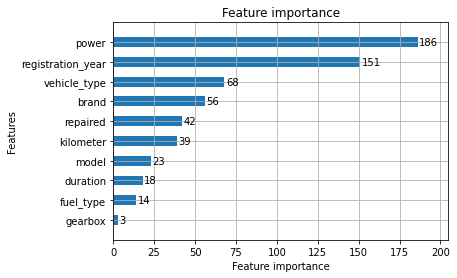

In [97]:
lgb.plot_importance(gbm, height=.5);

рейтинг признаков выглядит реалистично - на цену действительно влияет мощность двигателя и год изготовления в значительной мере. Также можно заметить, что признак repaired влияет не значительно, так что можно всё же осуществить предсказание его пропущенных значений методом машинного обучения в случае высоких значений метрики.

#### Подбор гиперпараметров

In [98]:
def algorithm_pipeline(X_train_data, X_test_data, y_train_data, y_test_data, 
                       model, param_grid, cv=10, scoring_fit='neg_mean_squared_error',
                       do_probabilities = False):
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid, 
        cv=cv, 
        n_jobs=-1, 
        scoring=scoring_fit,
        verbose=2
    )
    fitted_model = gs.fit(X_train_data, y_train_data)
    
    if do_probabilities:
        pred = fitted_model.predict_proba(X_test_data)
    else:
        pred = fitted_model.predict(X_test_data)
    
    return fitted_model, pred

In [99]:
%%time

lgb_train = lgb.Dataset(features_train_ord, target_train_ord)
lgb_eval = lgb.Dataset(features_valid_ord, target_valid_ord, reference=lgb_train)

param_grid = {
    "max_depth": [5, 10],
    "num_leaves": [10, 20]  
}

gbm_cv = lgb.LGBMRegressor()

gbm_cv, pred = algorithm_pipeline(features_train_ord, features_valid_ord, target_train_ord, target_valid_ord, gbm_cv, 
                                 param_grid, cv=5)

print(np.sqrt(-gbm_cv.best_score_))
print(gbm_cv.best_params_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
31.72162933232868
{'max_depth': 10, 'num_leaves': 20}
CPU times: user 11.9 s, sys: 198 ms, total: 12.1 s
Wall time: 27.6 s


In [100]:
%%time

lgb_train = lgb.Dataset(features_train_ord, target_train_ord)
lgb_eval = lgb.Dataset(features_valid_ord, target_valid_ord, reference=lgb_train)

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10],
}

gbm_cv2 = lgb.LGBMRegressor()

gbm_cv2, pred = algorithm_pipeline(features_train_ord, features_valid_ord, target_train_ord, target_valid_ord, gbm_cv2, 
                                 param_grid, cv=5)

print(np.sqrt(-gbm_cv2.best_score_))
print(gbm_cv2.best_params_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
30.942242956710178
{'max_depth': 10, 'n_estimators': 100}
CPU times: user 2.15 s, sys: 88.4 ms, total: 2.24 s
Wall time: 16.4 s


In [101]:
%%time

xgb_model = xgb.XGBRegressor()

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10],
}

xgb_model, pred = algorithm_pipeline(features_train_ord, features_valid_ord, target_train_ord, target_valid_ord, xgb_model, 
                                 param_grid, cv=5)

print(np.sqrt(-xgb_model.best_score_))
print(xgb_model.best_params_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[13:46:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
28.976381139659697
{'max_depth': 10, 'n_estimators': 100}
CPU times: user 21.3 s, sys: 228 ms, total: 21.5 s
Wall time: 2min 49s


Лучший результат!

In [102]:
%%time

CBM = CatBoostRegressor()

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10],
}

CBM, pred = algorithm_pipeline(features_train_ord, features_valid_ord, target_train_ord, target_valid_ord, CBM, 
                                 param_grid, cv=5)

print(np.sqrt(-CBM.best_score_))
print(CBM.best_params_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Learning rate set to 0.5
0:	learn: 60.8129422	total: 119ms	remaining: 11.8s
1:	learn: 46.1419995	total: 182ms	remaining: 8.9s
2:	learn: 40.4610525	total: 223ms	remaining: 7.21s
3:	learn: 37.0227581	total: 262ms	remaining: 6.29s
4:	learn: 35.6811608	total: 298ms	remaining: 5.67s
5:	learn: 34.6136323	total: 346ms	remaining: 5.43s
6:	learn: 34.0125163	total: 383ms	remaining: 5.08s
7:	learn: 33.4606034	total: 419ms	remaining: 4.82s
8:	learn: 33.0265054	total: 459ms	remaining: 4.64s
9:	learn: 32.5523517	total: 498ms	remaining: 4.49s
10:	learn: 32.1583232	total: 536ms	remaining: 4.33s
11:	learn: 31.8045724	total: 579ms	remaining: 4.24s
12:	learn: 31.5454320	total: 616ms	remaining: 4.12s
13:	learn: 31.4055356	total: 656ms	remaining: 4.03s
14:	learn: 31.2090010	total: 705ms	remaining: 4s
15:	learn: 30.9723581	total: 743ms	remaining: 3.9s
16:	learn: 30.7141149	total: 787ms	remaining: 3.84s
17:	learn: 30.6201610	total: 823ms	remaining: 

Вывод: у всех моделей, кроме XGB наилучшие параметры 'max_depth': 10, 'n_estimators': 100, тогда как XGB 'max_depth': 10, 'n_estimators': 50. Она же является наиболее долгой в работе. Проверим время отдельно обучения моделей и сведём результаты в таблицу

### Замер времени обучения моделей

In [103]:
model_performance = []

In [104]:
def model_assessment(model, params, features_train, target_train, features_test, target_test):
    st = datetime.datetime.now()
    model.fit(features_train, target_train)
    mt = datetime.datetime.now()
    y_pred = model.predict(features_test)
    et = datetime.datetime.now()
    
    learning_time = mt-st
    prediction_time = et-mt
    rmse = mean_squared_error(target_test_ord, y_pred) ** 0.5
    return rmse, learning_time, prediction_time

In [105]:
LR_model = LinearRegression()

param_grid = {
    'n_estimators': 100,
    'max_depth': 10,
}

rmse, learning_time, prediction_time = model_assessment(LR_model, param_grid, features_train_ord, target_train_ord, features_test_ord, target_test_ord)

model_performance.append(['LR_model', rmse, learning_time, prediction_time] )

In [106]:
DT_model = DecisionTreeRegressor()

param_grid = {
    'n_estimators': 100,
    'max_depth': 10,
}

rmse, learning_time, prediction_time = model_assessment(DT_model, param_grid, features_train_ord, target_train_ord, features_test_ord, target_test_ord)

model_performance.append(['Decision_Tree', rmse, learning_time, prediction_time] )

In [107]:
RF_model = RandomForestRegressor()

param_grid = {
    'n_estimators': 100,
    'max_depth': 10,
}

rmse, learning_time, prediction_time = model_assessment(RF_model, param_grid, features_train_ord, target_train_ord, features_test_ord, target_test_ord)

model_performance.append(['Random_Forest', rmse, learning_time, prediction_time] )

In [108]:
lgb_model = lgb.LGBMRegressor()

param_grid = {
    'n_estimators': 100,
    'max_depth': 10,
}

rmse, learning_time, prediction_time = model_assessment(lgb_model, param_grid, features_train_ord, target_train_ord, features_test_ord, target_test_ord)

model_performance.append(['LGB', rmse, learning_time, prediction_time] )

In [109]:
xgb_model = xgb.XGBRegressor()

param_grid = {
    'n_estimators': 50,
    'max_depth': 10,
}

rmse, learning_time, prediction_time = model_assessment(xgb_model, param_grid, features_train_ord, target_train_ord, features_test_ord, target_test_ord)

model_performance.append(['XGB', rmse, learning_time, prediction_time] )

[13:48:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [110]:
CBM = CatBoostRegressor()

param_grid = {
    'n_estimators': 100,
    'max_depth': 10,
}

rmse, learning_time, prediction_time = model_assessment(CBM, param_grid, features_train_ord, target_train_ord, features_test_ord, target_test_ord)

model_performance.append(['CBM', rmse, learning_time, prediction_time] )

Learning rate set to 0.085724
0:	learn: 86.7005680	total: 16.9ms	remaining: 16.8s
1:	learn: 81.6560468	total: 34ms	remaining: 17s
2:	learn: 77.1588610	total: 50.1ms	remaining: 16.7s
3:	learn: 73.1256438	total: 66.3ms	remaining: 16.5s
4:	learn: 69.5153773	total: 82.8ms	remaining: 16.5s
5:	learn: 66.3968074	total: 99ms	remaining: 16.4s
6:	learn: 63.4544199	total: 115ms	remaining: 16.3s
7:	learn: 60.7825691	total: 131ms	remaining: 16.2s
8:	learn: 58.4515678	total: 148ms	remaining: 16.3s
9:	learn: 56.3852884	total: 164ms	remaining: 16.2s
10:	learn: 54.5263075	total: 179ms	remaining: 16.1s
11:	learn: 52.8776686	total: 199ms	remaining: 16.4s
12:	learn: 51.3444088	total: 220ms	remaining: 16.7s
13:	learn: 50.0458861	total: 237ms	remaining: 16.7s
14:	learn: 48.8653419	total: 255ms	remaining: 16.8s
15:	learn: 47.7802920	total: 270ms	remaining: 16.6s
16:	learn: 46.8263900	total: 286ms	remaining: 16.5s
17:	learn: 45.9352815	total: 302ms	remaining: 16.5s
18:	learn: 45.1374174	total: 317ms	remaining

## Анализ моделей

In [111]:
model_performance = pd.DataFrame(model_performance, columns = ['Модель', 'RMSE',  'Время обучения', 'Время предсказания'])

In [112]:
model_performance

,Модель,RMSE,Время обучения,Время предсказания
0,LR_model,53.929759,0 days 00:00:00.043562,0 days 00:00:00.006687
1,Decision_Tree,39.967560,0 days 00:00:00.654680,0 days 00:00:00.010381
2,Random_Forest,31.011185,0 days 00:00:36.645017,0 days 00:00:00.770645
3,LGB,30.605402,0 days 00:00:01.146951,0 days 00:00:00.107144
4,XGB,34.948807,0 days 00:00:05.242646,0 days 00:00:00.047156
5,CBM,29.143125,0 days 00:00:16.700487,0 days 00:00:00.019618


Вывод:

Наилучший результат метрики RMSE показала модель CatBoost. Не сильно отстаёт от неё XGB. Random Forest из библиотеки sklearn показала себя лучше градиентного бустинга LightGBM. Дерево решений и линейная регрессия показали худшие результаты.

Наиболее быстрое обучение показали модели линейной регрессии и дерева решений. Из моделей на алгоритме градиентного бустинга наиболее быстрой по обучению оказалась CatBoost. Счёт на минуты обучения пошёл у моделей случайного леса, XGB и наиболее долго обучала модель LightGBM.

По времени предсказания рейтинг наиболее быстрых моделей тот же, а вот аутсайдеры немного поменялись местами. Модели на градиентном бустинге опередили модель случайного леса.

Итого, наиболее оптимальной моделью без всяких сомнений и недомолвок является CatBoost - лучший результат за кратчайшее время!